# Lab2

Group 7

## Exercise 1

In [13]:
# coding=utf-8
import pandas as pd
import re
import os
import numpy as np
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import spacy.cli
import contractions


class TextPreprocessing:
    def __init__(self, size):
        self.df0 = pd.read_csv('./data/netflix_titles.csv', encoding='utf8')
        self.df = self.df0.head(size).copy(deep=True)
        # optional columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
        #                   'release_year', 'rating', 'duration', 'listed_in', 'description']
        self.df['full_text'] = self.df["title"].map(str) + '. ' + \
                          self.df["director"].map(str) + '. ' + \
                          self.df["cast"].map(str) + '. ' + \
                          self.df["country"].map(str) + '. ' + \
                          self.df["date_added"].map(str) + '. ' + \
                          self.df["duration"].map(str) + '. ' + \
                          self.df["duration"].map(str) + '. ' + \
                          self.df["listed_in"].map(str) + '. ' + \
                          self.df["description"].map(str)
        self.corpus = self.df['full_text']
        pass

    def process(self):
        l = len(self.corpus)
        normalized_corpus = np.array([])
        n=0
        for i, doc in enumerate(self.corpus):
            n=i+1
            if n%100==0:
                print("%4d/%4d" % (n, l), end='\n')
            doc = doc.lower()

            '''
            HTMP strip
            '''
            doc = BeautifulSoup(doc, "html.parser").get_text()

            '''
            Contractions
            '''
            doc = contractions.fix(doc)

            '''
            Applying unicodedata normalizing
            '''
            # >> > s1 = 'Spicy Jalape\u00f1o'  # ”ñ”(U+00F1)
            # >> > s2 = 'Spicy Jalapen\u0303o'  # ”n~”(U+0303)
            # >> > s1
            # 'Spicy Jalapeño'
            # >> > s2
            # 'Spicy Jalapeño'
            # >> > s1 == s2
            # False
            # >> > len(s1)
            # 14
            # >> > len(s2)
            # 15
            tmp = unicodedata.normalize('NFKD', doc)  # see: https://en.wikipedia.org/wiki/Unicode_equivalence
            # >>> a
            # 'pýtĥöñ is awesome\n'
            # >>> b = unicodedata.normalize('NFD', a)
            # >>> b.encode('ascii', 'ignore').decode('ascii')
            # 'python is awesome\n'
            doc = tmp.encode('ascii', 'ignore').decode('utf-8', 'ignore')

            '''
            Applying lemmatization.
            Using stemming to get base word is important to know whether the word is positive or negative.
            But lemmatization gives the root forms of words.
            This helps in forming better machine learning features.
            '''
            # use en_core_web_sm to lemmatize text
            tmp = nlp(doc)
            doc = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in tmp])

            '''
            applying some regex replacing
            '''
            # remove punctuations
            p = '\[\]\.!,-;&:?"\''
            doc = re.sub(r'[{}]+'.format(p), ' ', doc)
            p = '[]'

            '''
            remove stopwords
            '''
            tokenizer = ToktokTokenizer()
            tokens = tokenizer.tokenize(doc)
            tokens = [token.strip() for token in tokens]
            filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]

            normalized_corpus = np.append(normalized_corpus, np.array(filtered_tokens))
        return normalized_corpus

if __name__ == '__main__':
    foo = TextPreprocessing(1)


### Test data for preprocessing

In [2]:
'''
prepare data
'''
doc = "<p>It's a better choice. These are 1537 corpora, we'd carry 16 more rocks, [ñ] !</p>\n<p>We'll NLP.... Spicy Jalape\u00f1o</p>"
print("[%15s] %s" % ('original text', doc))

[  original text] <p>It's a better choice. These are 1537 corpora, we'd carry 16 more rocks, [ñ] !</p>
<p>We'll NLP.... Spicy Jalapeño</p>


### HTMP strip

In [3]:
'''
HTMP strip
'''
doc = BeautifulSoup(doc, "html.parser").get_text()
print("[%15s] %s" % ('html stripping', doc))

[ html stripping] It's a better choice. These are 1537 corpora, we'd carry 16 more rocks, [ñ] !
We'll NLP.... Spicy Jalapeño


### Contractions

In [4]:
'''
Contractions
'''
doc = contractions.fix(doc)
print("[%15s] %s" % ('contractions', doc))

[   contractions] It is a better choice. These are 1537 corpora, we would carry 16 more rocks, [ñ] !
We will NLP.... Spicy Jalapeño


### Applying unicodedata normalizing

In [5]:
'''
Applying unicodedata normalizing
'''
# >> > s1 = 'Spicy Jalape\u00f1o'  # ”ñ”(U+00F1)
# >> > s2 = 'Spicy Jalapen\u0303o'  # ”n~”(U+0303)
# >> > s1
# 'Spicy Jalapeño'
# >> > s2
# 'Spicy Jalapeño'
# >> > s1 == s2
# False
# >> > len(s1)
# 14
# >> > len(s2)
# 15
tmp = unicodedata.normalize('NFKD', doc)  # see: https://en.wikipedia.org/wiki/Unicode_equivalence
# >>> a
# 'pýtĥöñ is awesome\n'
# >>> b = unicodedata.normalize('NFD', a)
# >>> b.encode('ascii', 'ignore').decode('ascii')
# 'python is awesome\n'
doc = tmp.encode('ascii', 'ignore').decode('utf-8', 'ignore')
print("[%15s] %s" % ('unicode norm', doc))

[   unicode norm] It is a better choice. These are 1537 corpora, we would carry 16 more rocks, [n] !
We will NLP.... Spicy Jalapeno


### Applying lemmatization

In [6]:
'''
Applying lemmatization.
Using stemming to get base word is important to know whether the word is positive or negative.
But lemmatization gives the root forms of words.
This helps in forming better machine learning features.
'''
# use en_core_web_sm to lemmatize text
nlp = spacy.load('en_core_web_sm')
tmp = nlp(doc)
doc = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in tmp])
print("[%15s] %s" % ('lemmatization', doc))

[  lemmatization] it be a well choice . these be 1537 corpus , we would carry 16 more rock , [ n ] ! 
 we will NLP .... Spicy Jalapeno


### Applying some regex replacing

In [7]:
'''
Applying some regex replacing
'''
# remove punctuations
punctuation = '\[\]\.!,;:?"\''
doc = re.sub(r'[{}]+'.format(punctuation), ' ', doc)
print("[%15s] %s" % ('punctuations', doc))

[   punctuations] it be a well choice   these be 1537 corpus   we would carry 16 more rock     n     
 we will NLP   Spicy Jalapeno


### Remove stopwords

In [8]:
'''
Remove stopwords
'''
stopword_list = nltk.corpus.stopwords.words('english')
tokenizer = ToktokTokenizer()
tokens = tokenizer.tokenize(doc)
tokens = [token.strip() for token in tokens]
filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
doc = ' '.join(filtered_tokens)
print("[%15s] %s" % ('stopwords', doc))

[      stopwords] well choice 1537 corpus would carry 16 rock n NLP Spicy Jalapeno


### Append some more stopwords to list

In [9]:
'''
prepare to run the whole process again
'''
nlp = spacy.load('en_core_web_sm')
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.append('nan')  # empty dataframe cell float np.nan
stopword_list.append('oh')
stopword_list.append('tv')
stopword_list.append('show')
stopword_list.append('movie')
# other stopwords
# sw_spacy = nlp.Defaults.stop_words

### Rerun the whole program again
rerun without detail logs

In [14]:
foo = TextPreprocessing(1000)
normalized_corpus = foo.process()

print()
print(normalized_corpus)

 100/1000
 200/1000
 300/1000
 400/1000
 500/1000
 600/1000
 700/1000
 800/1000
 900/1000
1000/1000

['dick' 'johnson' 'dead' ... 'life' 'everyone' 'board']


## Exercise 2

In [69]:
# coding=utf-8

import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from statsmodels.tsa.seasonal import seasonal_decompose
import mplfinance as mpf

import matplotlib

matplotlib.rc('font', size=5)


class TimeSerious:
    def __init__(self):
        self.decompose = None
        self.col = None
        self.auto_correlation_lag = None
        self.df = pd.read_csv('./data/google.csv')

    def time_series_decomposition(self, col):
        if self.decompose is None:
            self.decompose = seasonal_decompose(self.df[col], model='additive', period=100)
        return self.decompose

    def get_dist(self, resid, sample_size, bandwidth, isplot=False):
        _x_train = np.random.choice(resid, size=sample_size, replace=True).reshape(-1, 1)
        _x_test = np.linspace(math.floor(min(_x_train)), math.ceil(max(_x_train)), len(_x_train))[:, np.newaxis]
        h_vals = np.arange(bandwidth, bandwidth * 10, bandwidth)
        kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian', 'linear', 'tophat']
        grid = GridSearchCV(KernelDensity(), {'bandwidth': h_vals, 'kernel': kernels}, scoring=self.my_scores)
        grid.fit(_x_train)
        _best_kde = grid.best_estimator_
        _log_dens = _best_kde.score_samples(_x_test)
        _dist = np.exp(_log_dens)
        _dist = _dist + min(_dist)
        _dist = _dist / sum(_dist)
        if isplot:
            plt.fill(_x_test, _dist, c='cyan')
            plt.title("Best Kernel: " + _best_kde.kernel + " h=" + "{:.2f}".format(_best_kde.bandwidth))
            plt.show()
        return _x_test, _dist

    def get_residual_anomalies(self, d, x_test, residual):
        threshold = 0.997
        # residual_anomalies
        mid_idx = d.argmax()
        sum_l = sum(d[:mid_idx])
        idx_l = -1
        for i in range(mid_idx, idx_l, -1):
            if sum(d[i:mid_idx]) / sum_l > threshold:
                idx_l = i
                break
        anomaly_l = x_test[idx_l][0]
        sum_r = sum(d[mid_idx:])
        idx_r = len(d)
        for i in range(mid_idx, idx_r, 1):
            if sum(d[mid_idx:i]) / sum_r > threshold:
                idx_r = i
                break
        anomaly_r = x_test[idx_r][0]
        residual_anomalies = residual[(residual < anomaly_l) | (residual > anomaly_r)]
        residual_anomalies.name = 'anomalies'
        return residual_anomalies, anomaly_l, x_test[mid_idx], anomaly_r

    def job1_corr_exam(self):
        sns.set(rc={"figure.figsize":(8, 4)})
        fig = sns.heatmap(self.df.drop(['Date'], axis=1).corr(), annot=True, cmap='summer')
        heatmap = fig.get_figure()
        plt.show()
        heatmap.savefig("./output/job1_corr_on_heatmap.png")
        plt.clf()
        fig = sns.pairplot(self.df)
        plt.show()
        fig.savefig("./output/job1_corr_on_pairplot.png")
        pass

    def job2_show_the_volume_trend(self):
        decompose = self.time_series_decomposition('Volume')
        tr = decompose.trend
        tr = tr[tr == tr]
        fig = plt.figure(figsize=(10, 5), dpi=100, constrained_layout=True)
        ax = fig.add_subplot()
        ax.scatter(decompose.observed.index, decompose.observed, s=5, alpha=.8)
        ax.plot(tr.index.to_list(), tr.to_list(), linewidth=2, color='red')
        plt.suptitle("Visualize the trend in volume of stock data")
        fig.savefig("./output/job2_TS_trend.png")
        pass

    def job3_visualize_the_volume_outliers(self):
        decompose = self.time_series_decomposition('Volume')
        # decompose.plot()
        residual = decompose.resid.fillna(0)  # .apply(lambda x: round(-x, 2) if x < 0 else round(x, 2))
        x_test, dist = self.get_dist(residual, 500, 1 * 10000 * 100, isplot=False)
        residual_anomalies, l, m, r = self.get_residual_anomalies(dist, x_test, residual)

        # residual plot with dist histogram
        # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html
        # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#defining-the-axes-positions-using-inset-axes
        # https://blog.csdn.net/weixin_41298166/article/details/106273258
        fig = plt.figure(figsize=(10, 4), dpi=150, constrained_layout=True)
        gs = plt.GridSpec(4, 7, figure=fig, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
        ax_resid = fig.add_subplot(gs[1:, :-1])
        ax1 = fig.add_subplot(gs[1:, -1:], sharey=ax_resid)
        ax_volume = fig.add_subplot(gs[0, 0:-1])

        x = np.arange(len(residual))
        y = residual
        #
        self.plot_KDE(ax1, dist, l, m, r, x, x_test, y)
        self.plot_resid_and_its_anom(ax_resid, l, m, r, residual, residual_anomalies, x, y)
        self.plot_volume_and_its_anom(ax_volume, residual_anomalies, x)
        # plt.setp(baseline2, linewidth=1, color='yellow', markersize=10)
        # save fig
        plt.suptitle("Anomalies defined by TS Residual Distribution", fontsize=12)
        fig.savefig("./output/job3_visualize_the_volume_outliers.png")
        return

    def job4_calc_surpass_times(self):
        d = self.df.drop(['Adj Close'], axis=1)
        tmp = d["Open"] - d["Close"]
        title = "there are %d/%d surpassed days in google stock data" % (tmp[tmp > 0].size, tmp.size)
        path = "./output/job4_candle.png"

        d["Date"] = pd.to_datetime(d["Date"])
        d.set_index(["Date"], inplace=True)

        np.seterr(divide='ignore', invalid='ignore')  # ignore warning
        plt.rcParams['font.sans-serif'] = ['SimHei']  # show chinese character
        plt.rcParams['axes.unicode_minus'] = False  # show unicode minus

        # https://github.com/matplotlib/mplfinance/blob/master/examples/marketcolor_overrides.ipynb
        # https://github.com/matplotlib/mplfinance/blob/master/examples/savefig.ipynb
        mpf.plot(d, volume=True, style='yahoo', type='candle', savefig=path, title=title, warn_too_much_data=10000)
        plt.show()
        print(title)

    def get_tick_labels(self, x_max, cnt):
        arr = np.linspace(0, x_max, num=cnt, endpoint=True)
        steps = float("%.0e" % arr[1])
        labels = np.arange(0, x_max + steps, steps)
        return [str(round(float(label), 3)) for label in labels if label != '']

    def plot_KDE(self, ax1, dist, l, m, r, x, x_test, y):
        # ax1.title.set_text('KDE')
        ax1.set_title('KDE', fontdict={'fontsize': 9})
        ax1.hist(y, 80, histtype='stepfilled', orientation='horizontal', alpha=0.8)
        # [label.set_fontsize(7) for label in (ax1.get_xticklabels() + ax1.get_yticklabels())]
        [tick.set_color('steelblue') for tick in ax1.xaxis.get_ticklabels()]
        # ax1.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f°E'))
        ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        # KDE
        ax2 = ax1.twiny()
        ax2.plot(dist, x_test, '-.', color='r', linewidth=.8, alpha=1)
        labels = self.get_tick_labels(max(dist), 5)
        ax2.axis(xmin=0, xmax=max(dist)*1.05)
        # ax2.axis(xmin=0, xmax=float(labels[-1]))
        # ax2.set_xticks(np.arange(len(labels)))
        # ax2.set_xticklabels(['x'] * len(labels))

        [tick.set_color('red') for tick in ax2.xaxis.get_ticklabels()]
        # [label.set_fontsize(7) for label in (ax2.get_xticklabels())]
        # plot threshold in residuals
        ax2.plot(x, [l] * len(x), color='gray', linewidth=.2, alpha=.8)
        ax2.plot(x, [r] * len(x), color='gray', linewidth=.2, alpha=.8)
        ax2.plot(x, [m] * len(x), color='red', linewidth=.5, alpha=1)

    def plot_volume_and_its_anom(self, ax_volume, residual_anomalies, x):
        # ax_volume.title.set_text('volume')
        ax_volume.set_title('volume', fontdict={'fontsize': 9})
        # get volume anom
        a = pd.concat([self.df['Volume'], residual_anomalies], axis=1, ignore_index=False)
        a['anomalies'].fillna(0, inplace=True)  # a.loc[a['anomalies'] != a['anomalies'], 'Volume'] = 0
        ax_volume.axis(ymin=0, ymax=max(self.df['Volume']) * 1.1)
        ax_volume.axis(xmin=0, xmax=len(self.df['Volume']))
        # plot volume anom
        anom_x = a[a['anomalies'] != 0.0].index.values
        anom_y = a[a['anomalies'] != 0.0]['Volume'].values
        marker_line, stem_lines, baseline = ax_volume.stem(anom_x, anom_y, linefmt=':', markerfmt='o', bottom=0)
        plt.setp(stem_lines, lw=0.5)
        plt.setp(marker_line, lw=0.5, color='r', markersize=1)
        plt.setp(baseline, visible=False)
        # plot volume
        ax_volume.scatter(x, self.df['Volume'], s=4, alpha=.8, c="skyblue", edgecolors='gray', linewidths=.2)
        ax_volume.ticklabel_format(style='sci', scilimits=(-1, 2), axis='y')
        [label.set_fontsize(6) for label in (ax_volume.get_xticklabels() + ax_volume.get_yticklabels())]

    def plot_resid_and_its_anom(self, ax_resid, l, m, r, residual, residual_anomalies, x, y):
        # ax_resid.title.set_text('volume residual')
        ax_resid.set_title('volume residual', fontdict={'fontsize': 9})
        # plot residuals
        ax_resid.scatter(x, y, s=4, alpha=.8, c="skyblue", edgecolors='gray', linewidths=.2)
        # plot residuals anom
        anomalies_resid = pd.concat([residual, residual_anomalies], axis=1, ignore_index=False)
        marker_line, stem_line, baseline = ax_resid.stem(x, anomalies_resid['anomalies'],
                                                         linefmt=':', markerfmt='o', bottom=m)
        plt.setp(stem_line, lw=0.5)
        plt.setp(marker_line, lw=0.5, color='r', markersize=1)
        plt.setp(baseline, lw=0.5)
        # plot thresholds
        ax_resid.plot(x, [l] * len(x), color='gray', linewidth=.2, alpha=.8)
        ax_resid.plot(x, [r] * len(x), color='gray', linewidth=.2, alpha=.8)
        # reset x axis
        ax_resid.axis(xmin=0, xmax=len(y))
        [label.set_fontsize(6) for label in (ax_resid.get_xticklabels() + ax_resid.get_yticklabels())]
    
    def my_scores(self, estimator, X):
        scores = estimator.score_samples(X)
        # Remove -inf
        scores = scores[scores != float('-inf')]
        # Return the mean values
        return np.mean(scores)
        
if __name__ == '__main__':
    foo = TimeSerious()

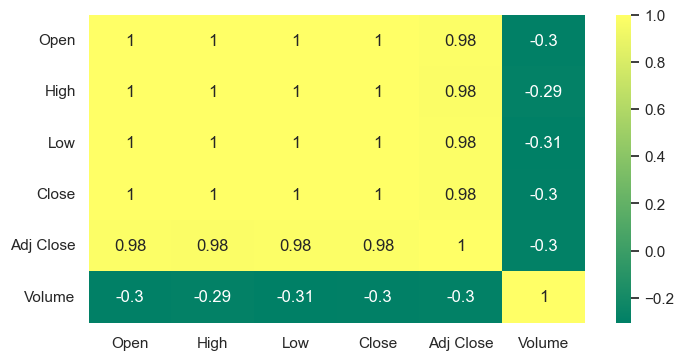

<Figure size 800x400 with 0 Axes>

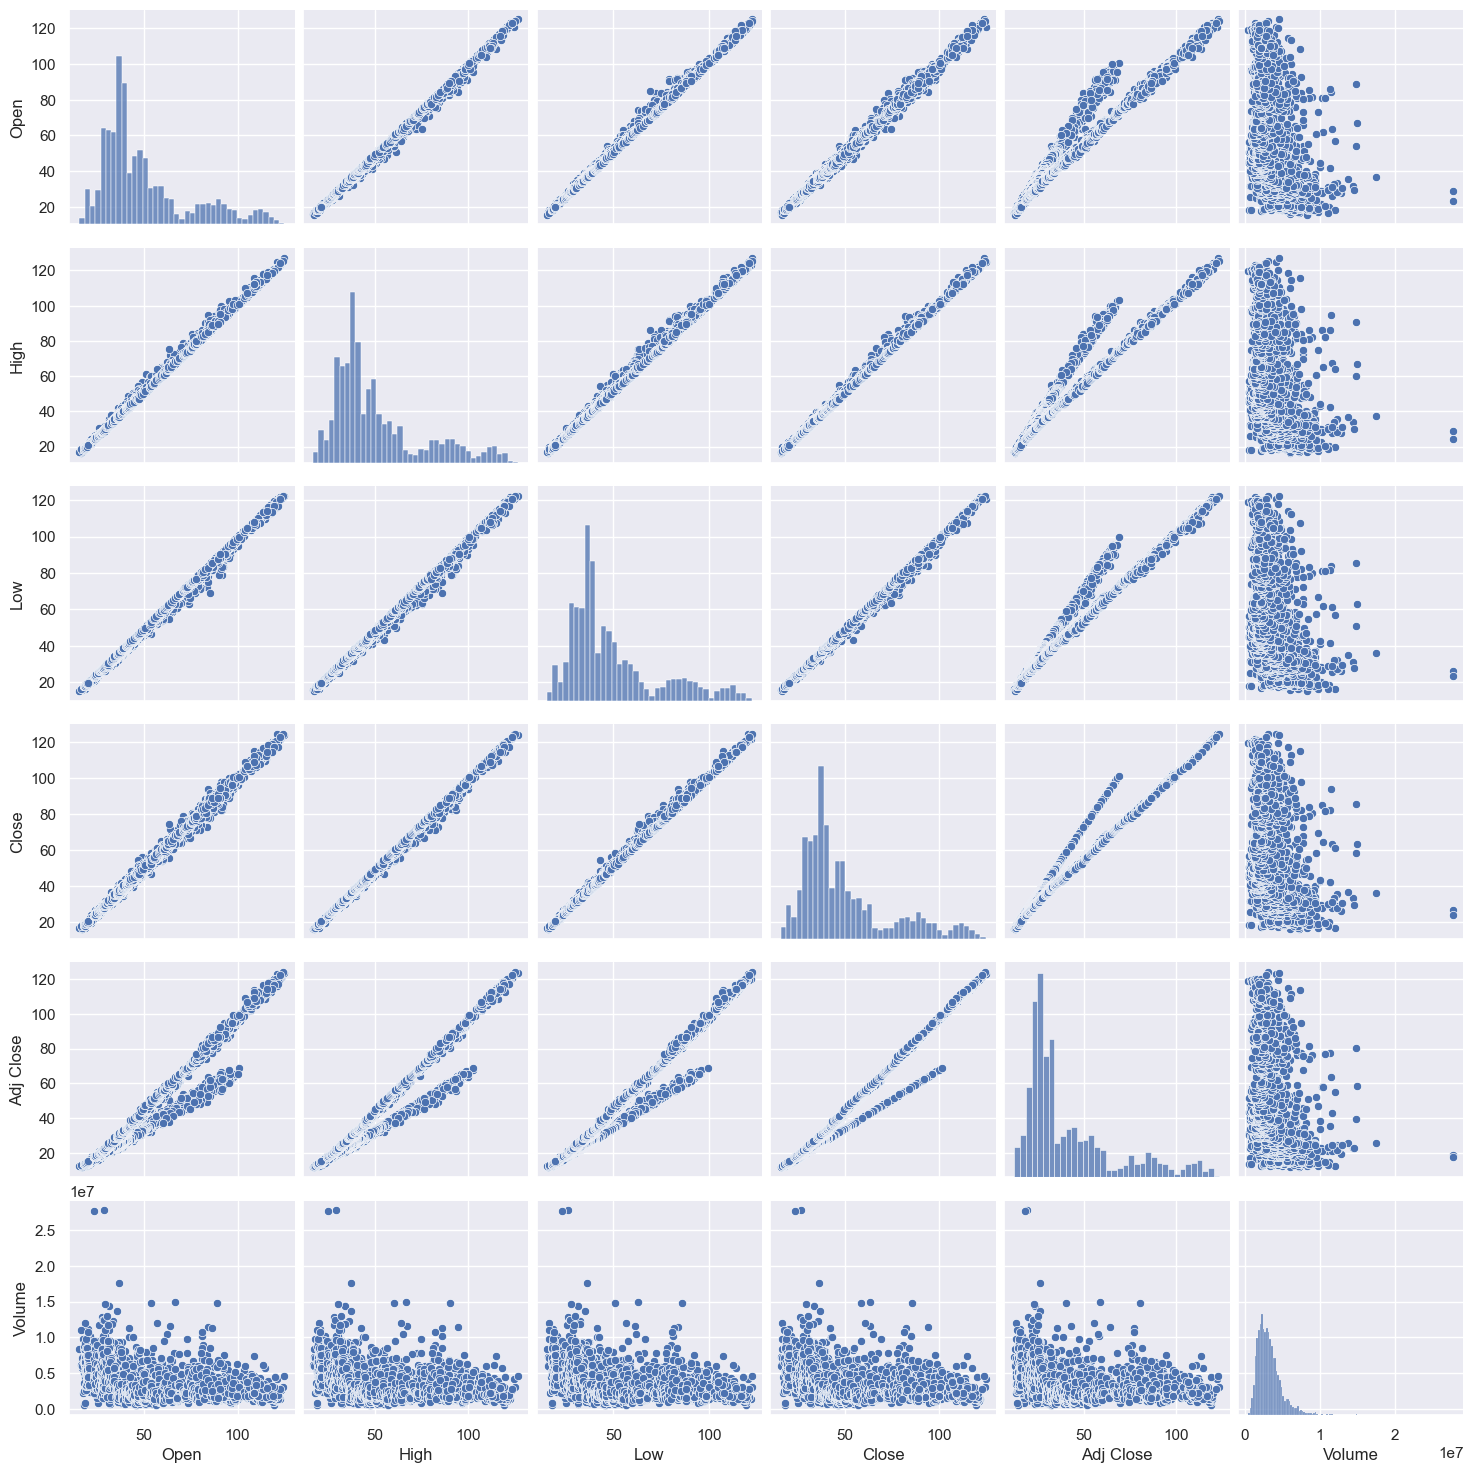

In [70]:
foo.job1_corr_exam()

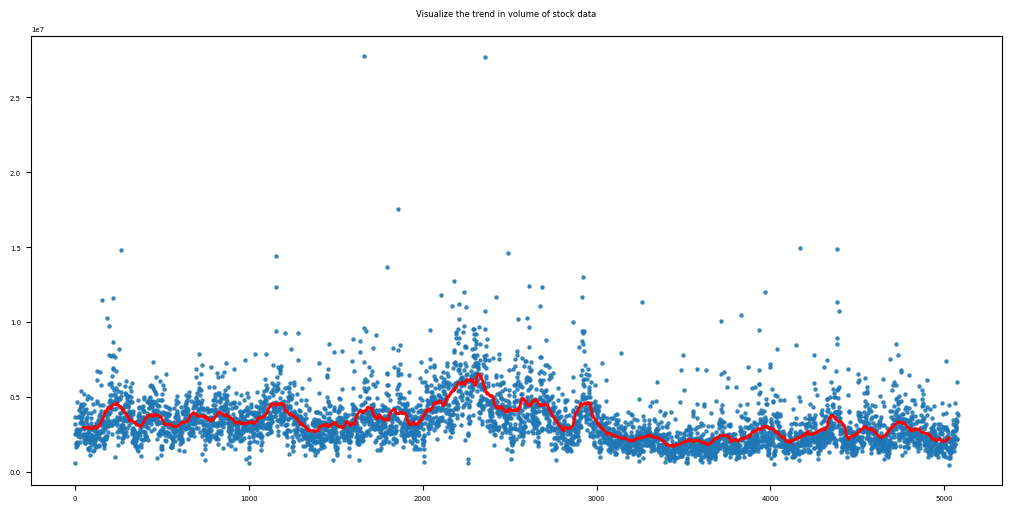

In [29]:
foo.job2_show_the_volume_trend()

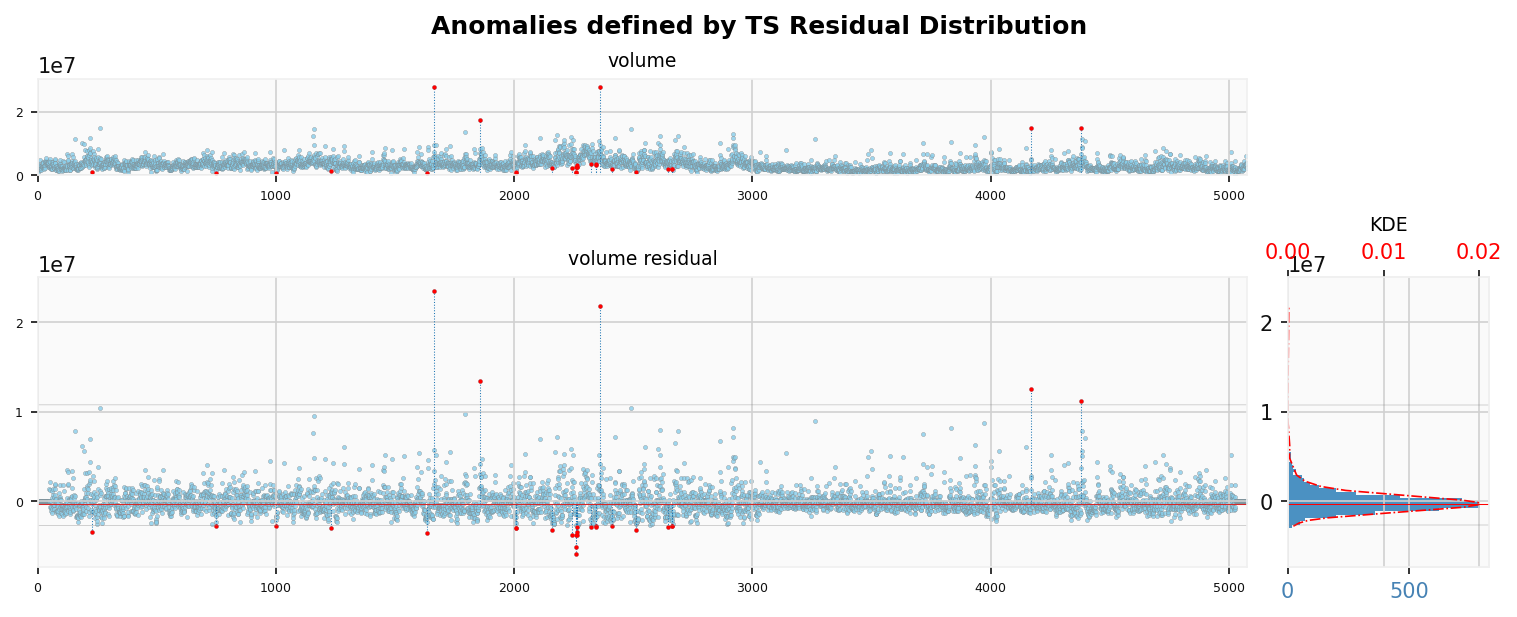

In [40]:
foo.job3_visualize_the_volume_outliers()

In [42]:
foo.job4_calc_surpass_times()

there are 2541/5077 surpassed days in google stock data
